In [1]:
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

## Parameters

In [2]:
S=276618
V=599864
W=97500
E=390
EB=39
I=974
IB=97
ICU=18
R=24500

UC=0.65*1000000
WC=0.005*1000000
H=ICU

y0 = [S,V,W,E,EB,I,IB,ICU,R,UC,WC]
y0H = [S,V,W,E,EB,I,IB,ICU,R,UC,WC,H]

M = sum(y0[:-2])

Rt_base = 3     # 0. - 3.5
ramping = 1
eta = 0.5
#kappa =0# 0.5 - 0.85
kappa = 0.9      # 0.7 - 0.95
sigma = 0.5      # 0.5 - 1.

gamma = 0.1      # 0.088 - 0.1
gamma_ICU = 0.1  # 0.08 - 0.2
delta = 0.007   # 0.00001 - 0.007
rho = 0.25

omega_v_b = 1./(6*30)
omega_n_b = 1./(12*30)

chi_0 = 0.1
chi_1 = 0.2

alpha_w = 0.008 # 0.005
alpha_u = 0.01
alpha_R = 8e-3 # 5e-3

n = 1.
k_v = M*omega_v_b*(1/(gamma+delta))
k_n = M*omega_n_b*(1/(gamma+delta))

e_R = 0.
e_u = 0.
e_w = 0.

Phi_0 = 0.0025
phi_0 = 0.0025

u_base = 0.5
w_max = 1-chi_1

tau_vac = 6*7 # from shot to immunization
tau_behaviour = 60
#mu=0
mu = 0.267
d_0 = 274
d_mu = 0.

npi_increase = 1.5

## Model

In [3]:
def funH(t,y):
    (S,V,W,E,EB,I,IB,ICU,R,UC,WC,H) = y
    
    I_eff = I + sigma*IB
    Gamma = 1 + mu*np.cos(2*np.pi*(t+d_0-d_mu)/365.)
    npi = 1 if t<180 else npi_increase
    Rt = Rt_base*np.exp(-alpha_R*ICU -e_R) * Gamma * npi

    u_max = 1 - chi_0
    u_w = u_base + (u_max-u_base)*(1-np.exp(-alpha_u*H-e_u))
    Phi = 0 if u_w<UC/M else min(Phi_0,u_w-UC/M)

    w_w = w_max*(1 - np.exp(-alpha_w*H-e_w))
    phi = 0 if w_w<WC/M else min(phi_0,WC/M)

    omega_v = omega_v_b*(1-(I_eff**n/((k_v/2)**n+I_eff**n)))
    omega_n = omega_n_b*(1-(I_eff**n/((k_n/2)**n+I_eff**n)))
    
    dS = -gamma*Rt*S/M*I_eff - Phi*M
    dV = -(1-eta)*gamma*Rt*V/M*I_eff + (Phi+phi)*M - omega_v*V
    dW = omega_v*V - gamma*Rt*W/M*I_eff - phi*M + omega_n*R
    dE = gamma*Rt*(S+W)/M*I_eff - rho*E
    dEB = (1-eta)*gamma*Rt*V/M*I_eff - rho*EB
    dI = rho*E - (gamma+delta)*I
    dIB = rho*EB - (gamma + delta*(1-kappa))*IB
    dICU = delta*(I+(1-kappa)*IB) - gamma_ICU*ICU
    dR = gamma*(I+IB) - omega_n*R + gamma_ICU*ICU
    dUC = M*Phi
    dWC = M*phi
    dH = ( data[int((t+tau_behaviour)/step_size)][7] - data[int(t/step_size)][7] ) / tau_behaviour
    #(ICU(t-t_vac) - ICU(t-t_vac-t_behavior))/tau
    
    return [dS,dV,dW,dE,dEB,dI,dIB,dICU,dR,dUC,dWC,dH]

## DDE solving

In [4]:
t_max = 360
step_size = 0.1
times = np.arange(0,t_max,step_size)

In [5]:
data = [y0H]*int((tau_vac+tau_behaviour)/step_size)

for i in range(len(times)-1):
    res = solve_ivp(funH, (times[i],times[i+1]), data[-1])
    data.append( res["y"][:,-1:].reshape(12) )

data = np.array(data)[-int(t_max/step_size):,:]

In [6]:
data[:,:-3].sum(axis=1)

array([1000000.        , 1000000.        , 1000000.        , ...,
       1000000.00000001, 1000000.00000001, 1000000.00000001])

## Plotting

In [7]:
def Gamma(t):
    return 1 + mu*np.cos(2*np.pi*(t+d_0-d_mu)/365.)
def npi(t):
    return (times>=180)*(npi_increase-1)+1
def Rt(Rt_base, ICU, t):
    return Rt_base*np.exp(-alpha_R*ICU -e_R) * Gamma(t) * npi(t)
def u_max():
    return 1 - chi_0
def u_w(ICU):
    return u_base + (u_max()-u_base)*(1-np.exp(-alpha_u*ICU-e_u))
def w_w(ICU):
    return w_max*(1-np.exp(-alpha_w*ICU-e_w))
def Phi(ICU,UC):
    return (u_w(ICU) >= UC/M)*np.minimum(Phi_0,u_w(ICU)-UC/M)
def phi(ICU,WC):
    return (w_w(ICU) >= WC/M)*np.minimum(phi_0,w_w(ICU)-WC/M)

In [8]:
# reset defaults
mpl.rcParams.update(mpl.rcParamsDefault)

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

#mpl.rcParams['axes.linewidth'] = 0.3
mpl.rcParams["axes.labelcolor"] = "black"
mpl.rcParams["axes.edgecolor"] = "black"
mpl.rcParams["xtick.color"] = "black"
mpl.rcParams["ytick.color"] = "black"

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

mpl.rcParams["xtick.labelsize"] = 8
mpl.rcParams["ytick.labelsize"] = 8
mpl.rcParams["axes.labelsize"] = 10
mpl.rcParams["axes.titlesize"]= 10
mpl.rcParams["legend.fontsize"] = 8
mpl.rcParams["legend.title_fontsize"] = 10

colors_paul = ["#233954", "#ea5e48", "#1e7d72", "#f49546", "#e8bf58", # dark
               "#5886be", "#f3a093", "#53d8c9", "#f2da9c", "#f9c192"] # light


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


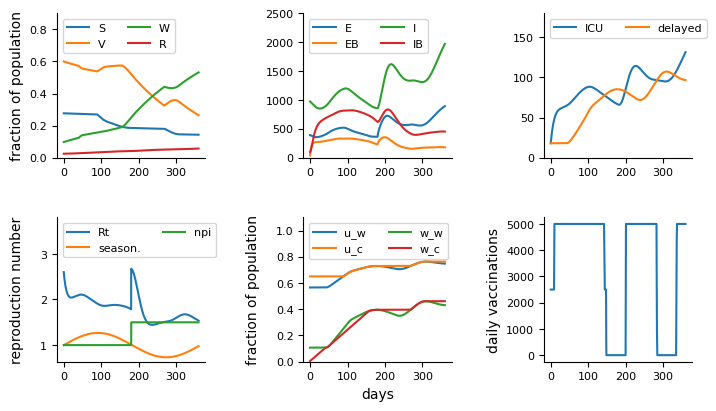

In [9]:
fig = plt.figure(figsize=(7, 4), constrained_layout=True)
grid = fig.add_gridspec(ncols=3, nrows=2, hspace=0.2, wspace=0.15)

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1],sharex=ax1)
ax3 = fig.add_subplot(grid[2],sharex=ax1)
ax4 = fig.add_subplot(grid[3],sharex=ax1)
ax5 = fig.add_subplot(grid[4],sharex=ax1)
ax6 = fig.add_subplot(grid[5],sharex=ax1)


ax1.plot(times,data[:,0]/1e6,label="S")
ax1.plot(times,data[:,1]/1e6,label="V")
ax1.plot(times,data[:,2]/1e6,label="W")
ax1.plot(times,data[:,8]/1e6,label="R")
ax1.set_ylim(0,0.9)
ax1.set_ylabel("fraction of population")
ax1.legend(loc='upper left', ncol=2)

ax2.plot(times,data[:,3],label="E")
ax2.plot(times,data[:,4],label="EB")
ax2.plot(times,data[:,5],label="I")
ax2.plot(times,data[:,6],label="IB")
ax2.set_ylim(0,2500)
ax2.legend(loc='upper left', ncol=2)

ax3.plot(times,data[:,7],label="ICU")
ax3.plot(times,data[:,11],label="delayed")
ax3.set_ylim(0,180)
ax3.legend(loc='upper left', ncol=2)

ax4.plot(times, Rt(Rt_base,data[:,7],times), label='Rt')
ax4.plot(times, Gamma(times), label='season.')
ax4.plot(times, npi(times), label='npi')
ax4.set_ylabel("reproduction number")
ax4.set_ylim(None,3.8)
ax4.legend(loc='upper left', ncol=2)

ax5.plot(times, u_w(data[:,11]), label='u_w')
ax5.plot(times, 1/M*data[:,9], label='u_c')
ax5.plot(times, w_w(data[:,11]), label='w_w')
ax5.plot(times, 1/M*data[:,10], label='w_c')
ax5.set_ylim(0,1.1)
ax5.set_xlabel("days")
ax5.set_ylabel("fraction of population")
ax5.legend(loc='upper left', ncol=2)

# something seams to be wrong here
ax6.plot(times, (Phi(data[:,7],data[:,9])+phi(data[:,7],data[:,10]))*M, label='(Phi+phi)*M')
ax6.set_ylabel("daily vaccinations")

fig.align_ylabels()

plt.show()
fig.savefig("./figures/model_tests.pdf")